# I. Problem

- The primary goal of this competition is to utilize our training data to predict the Severity Impairment Index (sii), a standard measure for evaluating Problematic Internet Use (PIU).
- The competition data is compiled into two sources, parquet files containing the accelerometer (actigraphy) series and csv files containing the remaining tabular data.
- The target variable is the Severity Impairment Index (sii), which reflects the degree of Internet influence on life, categorized into four levels: NONE, MILD, MODERATE, and SEVERE.

</div>

# II. Import the necessary libraries and load data from input files:

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np
import polars as pl
import pandas as pd
import plotly.express as px
from sklearn.base import clone
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from sklearn.impute import SimpleImputer, KNNImputer

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score

SEED = 42
n_splits = 5

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
train_origin = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_origin = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample_origin = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

# III. Viewing the data

In [11]:
# Make copies for use so that don't have to reload the data in the future.
train = train_origin.copy()
test = test_origin.copy()
sample = sample_origin.copy()

## Train data

In [6]:
display(train.head())
print(f"The train data has the shape: {train.shape}")

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


The train data has the shape: (3960, 82)


### Training Data
The training set has 3960 samples with 80 features excluding 'sii' and 'id'. By viewing the training dataset, we can see that there seem to be some NaN features in some rows.

## Test data

In [7]:
display(test.head())
print(f"The test data has the shape: {test.shape}")

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null


The test data has the shape: (20, 59)


## Target Variables and Internet use

* There are 22 PCIAT features. These comprise answers to 20 questions (each marked out of 5), the total score and 'season' when the test was carried out.
* The sii target is derived from the total PCIAT score:
    - 0-30 gives sii = 0
    - 31-49 gives sii = 1
    - 50-79 gives sii = 2
    - 80-100 gives sii = 3.
* We drop all the PCIAT features from the dataset except the PCIAT Total feature which can be used as a regression target.
* The PCIAT Total visualisation box plot shows us that many of the top scores look like outliers - yet this is our most important category.

In [23]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

In [25]:
train.sii.value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

Text(0.5, 1.0, 'Count of sii')

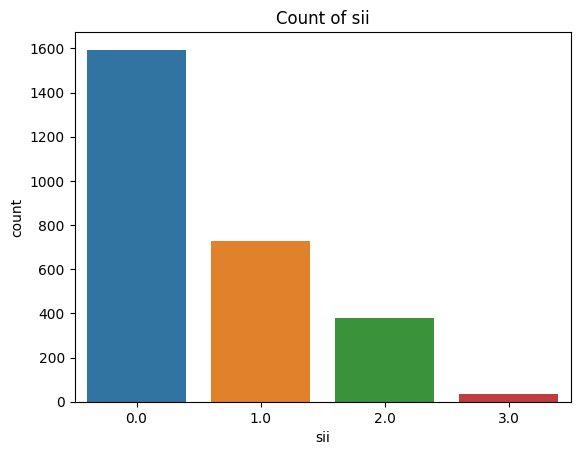

In [26]:
sns.countplot(train, x = 'sii').set_title('Count of sii')

In [15]:
(train
 .select(pl.col('PCIAT-PCIAT_Total'))
 .group_by(train.get_column('sii'))
 .agg(pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),
      pl.col('PCIAT-PCIAT_Total').len().alias('count'))
 .sort('sii')
)

sii,PCIAT-PCIAT_Total min,PCIAT-PCIAT_Total max,count
i64,i64,i64,u32
null,null,null,1224
0,0,30,1594
1,31,49,730
2,50,79,378
3,80,93,34


## Catagory Variables

In [13]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,nu

## Missing Values
All columns seem to have a large amount of missing values, except for 'id' as well as 'sex', 'age' and season of enrollment.

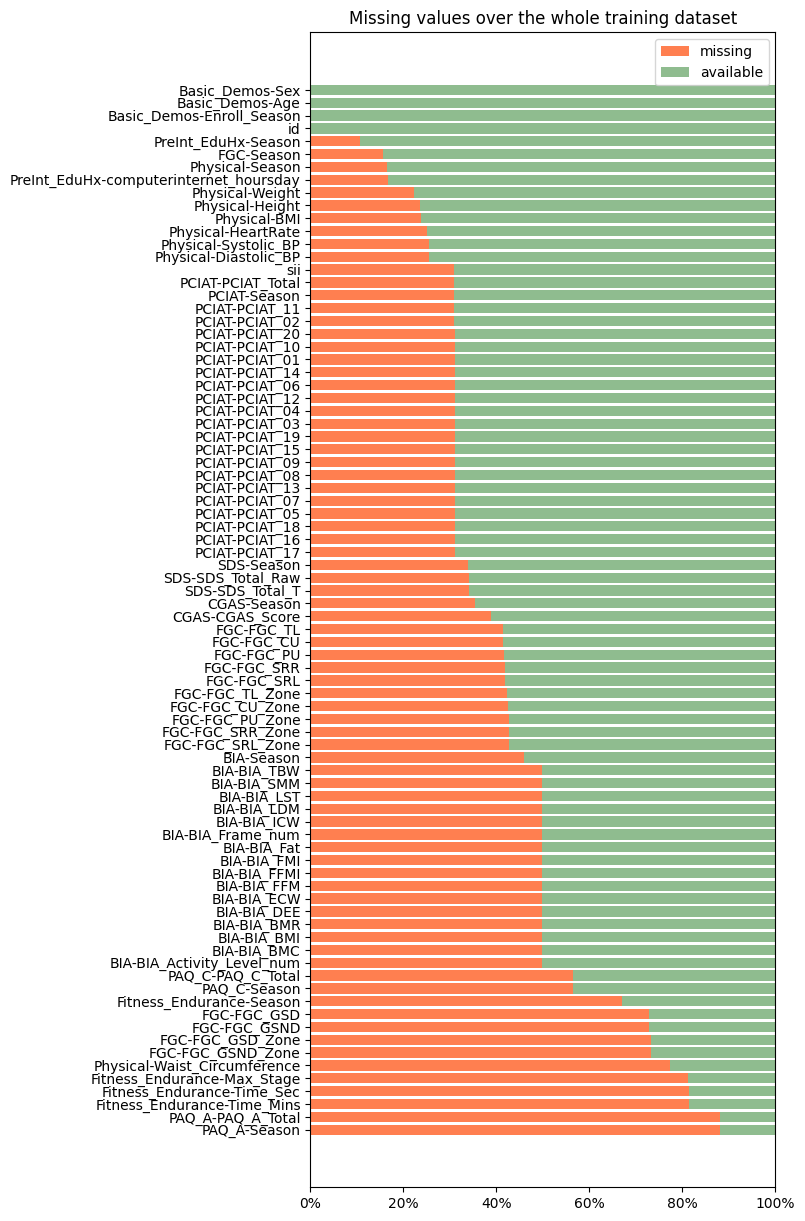

In [14]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title('Missing values over the whole training dataset')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

### Test Set

The test set does not have an PCIAT columns, as PCIAT columns can be used to directly map to 'sii'

- We should try to predict the target without the PCIAT features
- We can either directly predict **'sii'** using some type of classification **or** use a regression model to predict **PCIAT_Total** which can then be mapped to **'sii'**

### Actigraphy

Looking at the file of participant id=417c91e, we can see that:
- She moves alot as enmo > 2 everyday
- She is in an environment where lux exceeds 2500 every day.

In [ ]:
# View the actigraphy
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

A boy who only sees daylight once a month and does not move much

In [ ]:
analyze_actigraphy('5f9dddb4', small=True)

Strange ramps in between the lights $\rightarrow$ Maybe some missing data was filled in.

In [ ]:
analyze_actigraphy('bc4eaf77', small=True)

We can conclude that the actigraphy need some data cleaning

In [ ]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [ ]:
train_ts_origin = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts_origin = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

In [ ]:
train = train_origin.copy()
test = test_origin.copy()
sample = sample_origin.copy()

train_ts = train_ts_origin.copy()
test_ts = test_ts_origin.copy()

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

# drop rows with thresholds dropna(thresh=N):
# Retains rows with at least N non-null values.
# If a row has fewer than N non-null values, it will be dropped

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

In [ ]:
def feature_engineering(df):
    # 1. Interaction Features:
    df['Age_and_BMI'] = df['Basic_Demos-Age'] * df['Physical-BMI']
    df['BP_Difference'] = df['Physical-Systolic_BP'] - df['Physical-Diastolic_BP']
    # 2. Aggregated Features:
    df['Avg_BMI'] = df.groupby('Physical-Season')['Physical-BMI'].transform('mean')
    df['BMI_Per_Weight'] = df['Physical-BMI'] / df['Physical-Weight']
    
    # 3. Temporal Features:
    df['Seasonal_BP'] = df.groupby('Physical-Season')['Physical-Diastolic_BP'].transform('mean')
    # 5. Ratios and Proportions:
    df['BMI_Height_Ratio'] = df['Physical-BMI'] / df['Physical-Height']
    df['HeartRate_to_Weight'] = df['Physical-HeartRate'] / df['Physical-Weight']

    # 6. Health Metrics:
    df['Frame_to_BMI'] = df['BIA-BIA_Frame_num'] / df['Physical-BMI']
    
    return df
    
train = feature_engineering(train)
test = feature_engineering(test)

train.shape

In [ ]:
test.shape

In [ ]:
 if np.any(np.isinf(train)):
   train = train.replace([np.inf, -np.inf], np.nan)

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,model

In [ ]:
# Testing Parameters for first run
Params = {'learning_rate': 0.03884249148676395, 'max_depth': 12, 'num_leaves': 413, 'min_data_in_leaf': 14,
           'feature_fraction': 0.7987976913702801, 'bagging_fraction': 0.7602261703576205, 'bagging_freq': 2, 
           'lambda_l1': 4.735462555910575, 'lambda_l2': 4.735028557007343e-06} # CV : 0.4094 | LB : 0.471

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}

CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

Light = LGBMRegressor(**Params,random_state=SEED, verbose=-1,n_estimators=200)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

Submission,model = TrainML(voting_model, test)

In [ ]:
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())